# 4. Estimating Uncertainty In Classification Predictions (분류 예측의 불확실성 추정)
- 어떤 테스트 포인트에 대해 분류기가 예측한 클래스가 무엇인지 뿐만 아니라 정확한 클래스임을 얼마나 확신하는지가 중요할 때가 많음
- 실제 애플리케이션에서는 오류의 종류에 따라 전혀 다른 결과를 만듦
- 암을 진ㄷ단하는 의료 애플리케이션의 경우, 거짓 양성(False Positive) 예측은 환자에게 추가 진료를 요구하겠지만 거짓 음성(False Negative) 예측은 심각한 질병을 치료하지 못하게 만들 수 있음
- scikit-learn 분류기에서 불확실성을 추정할 수 있는 함수가 두 개 있음
- decision_function과 predict_proba임
- 대부분의(전체는 아니고) 분류 클래스는 적어도 둘 중 하나를 제공하고 두 함수를 모두 제공하는 경우도 많음

In [25]:
# 인위적으로 만든 2차원 데이터셋을 사용해 GradientBoostingClassifier 분류기의 decision_function과 predict_proba 메서드가 어떤 역할을 하는지 확인
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import numpy as np
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

# 예제를 위해 클래스의 이름을 "blue"와 "red"로 바꿈
y_named = np.array(["blue", "red"])[y]

# 여러 개의 배열을 한꺼번에 train_test_split에 넣을 수 있음
# 훈련 세트와 테스트 세트로 나뉘는 방식은 모두 같음
X_train, X_test, y_train_named, y_test_named, y_train, y_test = train_test_split(X, y_named, y, random_state=0)

# 그레이디언트 부스팅 모델을 만듦
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(random_state=0)

## 4-1. 결정 함수
- 이진 분류에서 decision_function 반환값의 크기는 (n_sample,)이며 각 샘플이 하나의 실수 값을 반환

In [26]:
print("X_test.shape:", X_test.shape)
print("결정 함수 결과 형태:", gbrt.decision_function(X_test).shape)

X_test.shape: (25, 2)
결정 함수 결과 형태: (25,)


- 이 값은 모델이 데이터 포인트가 양성 클래스인 클래스 1에 속한다고 믿는 정도
- 양수 값은 양성 클래스를 의미하며 음수 값은 음성 (즉 다른) 클래스를 의미

In [27]:
# 결정 함수 결과 중 앞부분 일부를 확인
print("결정 함수:\n", gbrt.decision_function(X_test)[:6])

결정 함수:
 [ 4.13592603 -1.67785652 -3.95106099 -3.62604651  4.28986642  3.66166081]


In [28]:
# 결정 함수의 부호만 보고 예측 결과를 알 수 있음
print("임계치와 결정 함수 결과 비교:\n", gbrt.decision_function(X_test) > 0)
print("예측:\n", gbrt.predict(X_test))

임계치와 결정 함수 결과 비교:
 [ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
예측:
 ['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


In [29]:
# 이진 분류에서 음성 클래스는 항상 classes_ 속성의 첫 번째 원소이고 양성 클래스는 classes_의 두 번째 원소
# 그래서 predict 함수의 결과를 완전히 재현하려면 classes_ 속성을 사용
# boolean 값을 0과 1로 반환
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# classes_에 인덱스로 사용
pred = gbrt.classes_[greater_zero]
# pred와 gbrt.predict의 결과를 비교
print("pred는 예측 결과와 같다:", np.all(pred == gbrt.predict(X_test)))

pred는 예측 결과와 같다: True


In [30]:
# decision_function 값의 범위는 데이터와 모델 파라미터에 따라 달라짐
decision_function = gbrt.decision_function(X_test)
print("결정 함수 최솟값: {:.2f} 최댓값: {:.2f}".format(np.min(decision_function), np.max(decision_function)))

결정 함수 최솟값: -7.69 최댓값: 4.29


AttributeError: 'Colorbar' object has no attribute 'draw_all'

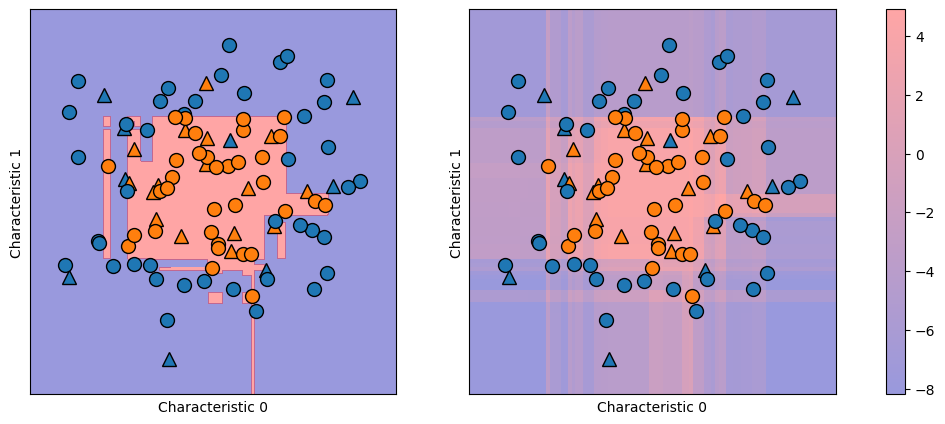

In [34]:
# decision_function의 출력 범위가 임의의 값이라 이해하긴 어려움
# 2차원 평면의 모든 점에 대해 decision_function의 값을 색으로 표현하여 앞서본 결정 경계와 함께 그래프로 나타냄
# 훈련 데이터는 원 모양이고, 테스트 데이터는 삼각형
import matplotlib.pyplot as plt
import mglearn

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=0.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=0.4, cm=mglearn.ReBl)

for ax in axes:
  # 훈련 포인트와 테스트 포인트를 그리고
  mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
  mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
  ax.set_xlabel("Characteristic 0")
  ax.set_ylabel("Characteristic 1")

cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test Class 0", "Test Class 1", "Training Class 0", "Training Class 1"], ncol=4, loc=(0.1, 1.1))

- 예측한 결과뿐만 아니라 분류기가 얼마나 확신하는지를 알면 추가 정보를 얻게 됨
- 그러나 결정 함수 그래프에서 두 클래스 사이의 경계를 구분하기는 어려움

## 4-2. 예측 확률
- predict_proba의 출력은 각 클래스에 대한 확률이고 decision_function의 출력보다 이해하기가 더 쉬움
- 이 값의 크기는 이진 분류에서는 항상 (n_samples, 2)

In [32]:
print("확률 값의 형태:", gbrt.predict_proba(X_test).shape)

확률 값의 형태: (25, 2)


- 각 항의 첫 번째 원소는 첫 번째 클래스의 예측 확률이고 두 번째 원소는 두 번째 클래스의 예측 확률
- 확률이기 때문에 predict_proba의 출력은 항상 0과 1 사이의 값이며 두 클래스에 대한 확률의 합은 항상 1

In [33]:
# predict_proba 결과 중 앞부분 일부를 확인
print("예측 확률:\n", gbrt.predict_proba(X_test[:6]))

예측 확률:
 [[0.01573626 0.98426374]
 [0.84262049 0.15737951]
 [0.98112869 0.01887131]
 [0.97406909 0.02593091]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


- 두 클래스의 확률 합은 1이므로 두 클래스 중 하나는 50% 이상의 확신을 가질 것이고, 바로 그 클래스가 예측값이 됨
- 앞의 출력 값을 보면 분류기가 대부분의 포인트에서 비교적 강하게 확신
- 데이터에 있는 불확실성이 얼마나 이 값에 잘 반영되는지는 모델과 매개변수 설정에 달렸음
- 과대적합된 모델은 예측에 불확실성이 더 많음
- 이런 불확실성과 모델의 정확도가 동등하면 이 모델이 보정(calibration)되었다고 함
- 보정된 모델에서 70% 확신을 가진 예측은 70%의 정확도를 낼 것

AttributeError: 'Colorbar' object has no attribute 'draw_all'

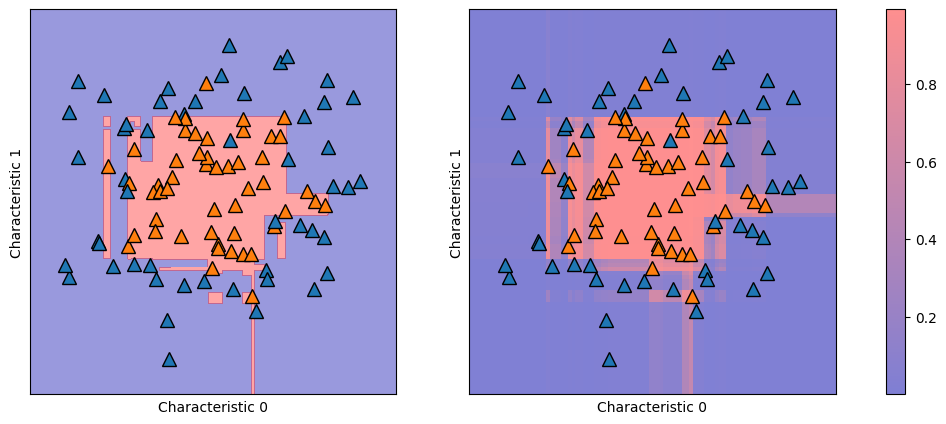

In [35]:
# 결정 경계와 클래스 1의 확률을 그려봄

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=0.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=0.5, cm=mglearn.ReBl, function="predict_proba")

for ax in axes:
  # 훈련 포인트와 테스트 포인트를 그리기
  mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
  mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='^', ax=ax)
  ax.set_xlabel("Characteristic 0")
  ax.set_ylabel("Characteristic 1")
# colorbar를 감추지 않음
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test Class 0", "Test Class 1", "Training Class 0", "Training Class 1"], ncol=4, loc=(0.1, 1.1))

- 그레이디언트 부스팅 모델의 결정 경계(좌)와 예측 확률(우)
- 이 그래프의 경계는 훨씬 잘 나타나 있으며 불확실성이 있는 작은 영역들도 잘 확인할 수 있음

## 4-3. 다중 분류에서의 불확실성
- decision_function과 predict_proba 메서드는 다중 분류에도 사용할 수 있음
- 클래스가 세 개인 iris 데이터셋에 적용

In [36]:
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

print("결정 함수의 결과 형태:", gbrt.decision_function(X_test).shape)
# decision function 결과 중 앞부분 일부를 확인
print("결정 함수 결과:\n", gbrt.decision_function(X_test)[:6, :])

결정 함수의 결과 형태: (38, 3)
결정 함수 결과:
 [[-1.995715    0.04758267 -1.92720695]
 [ 0.06146394 -1.90755736 -1.92793758]
 [-1.99058203 -1.87637861  0.09686725]
 [-1.995715    0.04758267 -1.92720695]
 [-1.99730159 -0.13469108 -1.20341483]
 [ 0.06146394 -1.90755736 -1.92793758]]


- 다중 분류에서는 decision_function의 결과값의 크기는 (n_samples, n_classes)
- 각 열은 각 클래스에 대한 확신 점수를 담고 있음
- 수치가 크면 그 클래스일 가능성이 크고, 수치가 작으면 그 클래스일 가능성이 낮음
- 데이터 포인트마다 점수들에서 가장 큰 값을 찾아 예측 결과를 재현할 수 있음

In [38]:
print("가장 큰 결정 함수의 인덱스:\n", np.argmax(gbrt.decision_function(X_test), axis=1))
print("예측:\n", gbrt.predict(X_test))

# predict_proba의 출력값 크기는 (n_samples, n_classes)로, 앞서 본 것과 같음
# 마찬가지로 각 데이터 포인트에서 클래스 확률의 값은 1

가장 큰 결정 함수의 인덱스:
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
예측:
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [39]:
# predict_proba 결과 중 앞부분 일부를 확인
print("예측 확률:\n", gbrt.predict_proba(X_test)[:6])
# 행 방향으로 확률을 더하면 1이 됨
print("합:", gbrt.predict_proba(X_test)[:6].sum(axis=1))

예측 확률:
 [[0.10217718 0.78840034 0.10942248]
 [0.78347147 0.10936745 0.10716108]
 [0.09818072 0.11005864 0.79176065]
 [0.10217718 0.78840034 0.10942248]
 [0.10360005 0.66723901 0.22916094]
 [0.78347147 0.10936745 0.10716108]]
합: [1. 1. 1. 1. 1. 1.]


In [40]:
# predict_proba의 결과에 argmax 함수를 적용해서 예측을 재현할 수 있음
print("가장 큰 예측 확률의 인덱스:\n", np.argmax(gbrt.predict_proba(X_test), axis=1))
print("예측:\n", gbrt.predict(X_test))

가장 큰 예측 확률의 인덱스:
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
예측:
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


- predict_proba와 decision_function의 결과값 크기는 항상 (n_samples, n_classes)임
- 이진 분류의 decision_function은 열이 하나뿐이며 양성 클래스인 classes_[1]에 대응하는 값을 가지고있는데, 이는 아마 관례 때문일 것
- 열이 n_classes개일 때는 열을 가로질러서 argmax 함수를 적용해 예측 결과를 재현할 수 있음
- 하지만 주의할 것은 클래스가 문자열이나 또는 정수형을 사용하지만 연속적이지 않고 0부터 시작하지 않을 수 있음
- predict의 결과와 decision_function이나 predict_proba의 결과를 비교하려면 분류기의 classes_ 속성을 사용해 클래스의 실제 이름을 얻어야 함

In [41]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)

# iris 데이터셋의 타깃을 클래스 이름으로 나타내기
named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
print("훈련 데이터에 있는 클래스 종류:", logreg.classes_)
print("예측:", logreg.predict(X_test)[:10])
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("가장 큰 결정 함수의 인덱스:", argmax_dec_func[:10])
print("인덱스를 classes_에 연결", logreg.classes_[argmax_dec_func][:10])

훈련 데이터에 있는 클래스 종류: ['setosa' 'versicolor' 'virginica']
예측: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
가장 큰 결정 함수의 인덱스: [1 0 2 1 1 0 1 2 1 1]
인덱스를 classes_에 연결 ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
